In [1]:
import os
import requests
import urllib
import sys
from typing import List, Tuple, Dict, Any

FILE_URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

In [2]:
def download(url: str) -> None:
    file_name = url.split("/")[-1]
    download_path = file_name

    if os.path.exists(download_path):
        print("Already downloaded!")

    else:
        # ============================================ download
        print("Downloading, sit tight!")

        def _progress(count, block_size, total_size):
            sys.stdout.write(
                f"\r>> Downloading {file_name} {float(count * block_size) / float(total_size) * 100.0}%")
            sys.stdout.flush()

        file_path, _ = urllib.request.urlretrieve(
            url, download_path, _progress)
        print()
        print(
            f"Successfully downloaded {file_name} {os.stat(file_path).st_size} bytes")
        
        
download(FILE_URL)

Downloading, sit tight!
>> Downloading input.txt 100.61951202893327%
Successfully downloaded input.txt 1115394 bytes


In [3]:
import re
import string


def remove_punctuation(text: str) -> str:
    return re.sub(f"[{re.escape(string.punctuation)}]", "", text)

def read_all_text(file_path: str) -> str:
    assert os.path.exists(file_path)

    with open(file_path, "r") as f:
        data = f.read()

    # remove new line escape sequences
    data = data.replace("\n", " ")
    # remove double spaces
    data = data.replace("  ", " ")
    # trim trailing whitespace
    data = data.strip()
    # remove punctuation
    data = remove_punctuation(data)
    # lower case
    data = data.lower()

    return "[START] " + data + " [END]"


all_text = read_all_text("input.txt")

In [4]:
def tokenize(text: str, remove_sw=False) -> list:
    s = text.split(" ")
    return s

all_tokens = tokenize(all_text)

In [5]:
from collections import Counter

vocabulary = Counter(all_tokens)
# sort by frequency, ascending
vocabulary = sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)
vocabulary[:10]

[('the', 6283),
 ('and', 5680),
 ('to', 4766),
 ('i', 4653),
 ('of', 3757),
 ('you', 3142),
 ('my', 3118),
 ('a', 2987),
 ('that', 2569),
 ('in', 2362)]

In [6]:
vocabulary_size = len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 12851


In [7]:
top_20_words = vocabulary[:20]

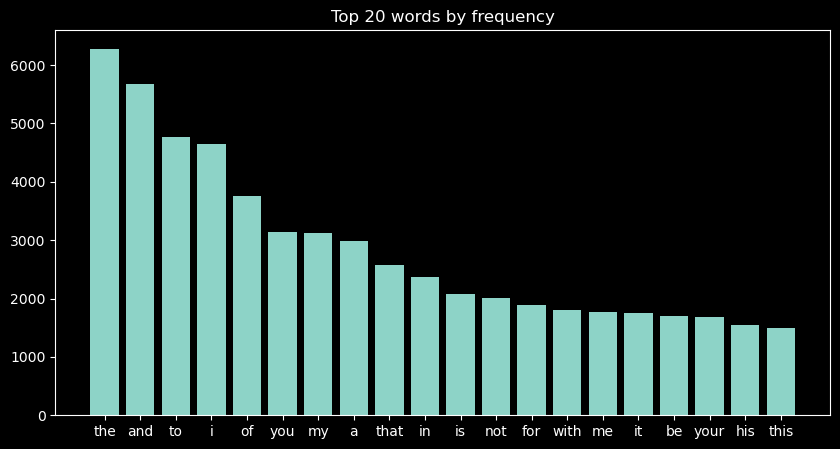

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot top 50 words as a bar chart
plt.figure(figsize=(10, 5))
plt.bar([x[0] for x in top_20_words], [x[1] for x in top_20_words]) 
plt.title("Top 20 words by frequency")
plt.show()

In [9]:
# create bigrams from all_tokens
bigrams = [(all_tokens[i], all_tokens[i+1]) for i in range(len(all_tokens)-1)]
bigrams[:10]

[('[START]', 'first'),
 ('first', 'citizen'),
 ('citizen', 'before'),
 ('before', 'we'),
 ('we', 'proceed'),
 ('proceed', 'any'),
 ('any', 'further'),
 ('further', 'hear'),
 ('hear', 'me'),
 ('me', 'speak')]

In [10]:
bigram_counts = Counter(bigrams)
# sort by frequency, ascending
bigram_counts = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
bigram_counts[:10]

[(('to', 'the'), 390),
 (('i', 'am'), 376),
 (('my', 'lord'), 360),
 (('i', 'have'), 358),
 (('in', 'the'), 335),
 (('of', 'the'), 306),
 (('i', 'will'), 281),
 (('it', 'is'), 252),
 (('king', 'richard'), 250),
 (('to', 'be'), 243)]

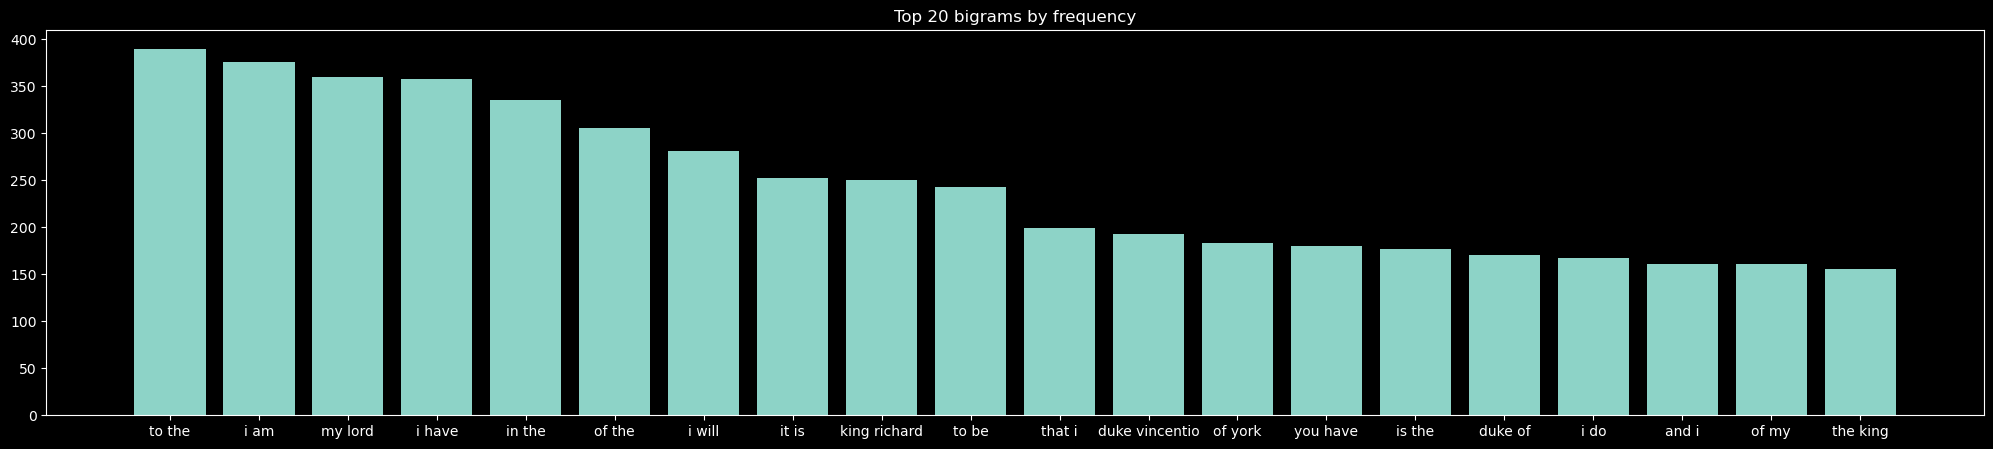

In [11]:
top_20_bigrams = bigram_counts[:20]
# plot top 20 bigrams as a bar chart
plt.figure(figsize=(25, 5))
plt.bar([" ".join(x[0])  for x in top_20_bigrams], [x[1] for x in top_20_bigrams])
plt.title("Top 20 bigrams by frequency")
plt.show()

In [12]:
def get_unigram_probabilities(tokens):
    unigram_counts = Counter(tokens)
    total_count = len(tokens)
    unigram_probabilities = {k: v/total_count for k, v in unigram_counts.items()}
    return unigram_probabilities

unigram_probabilities = get_unigram_probabilities(all_tokens)

In [13]:
def get_bigram_probabilities(bigrams):
    bigram_counts = Counter(bigrams)
    total_count = len(bigrams)
    bigram_probabilities = {k: v/total_count for k, v in bigram_counts.items()}
    
    return bigram_probabilities

bigram_probabilities = get_bigram_probabilities(bigrams)

In [14]:
word_to_idx = {w: i for i, (w, _) in enumerate(vocabulary)}
idx_to_word = {i: w for i, (w, _) in enumerate(vocabulary)}

In [15]:
import torch
torch.manual_seed(42)

In [16]:
idxs = torch.multinomial(torch.tensor(list(unigram_probabilities.values())), 10)
idxs

tensor([  33,  119, 1839, 2261,   12, 5657,   48,   67,  594,  261])

In [17]:
" ".join([idx_to_word[i.item()] for i in idxs])

'king lady boar hire for garlands from am saint power'

In [18]:
def generate(probabilities, idx_to_word, num_words=10):
    idxs = torch.multinomial(torch.tensor(list(probabilities.values())), num_words)
    return " ".join([idx_to_word[i.item()] for i in idxs])

In [19]:
generate(unigram_probabilities, idx_to_word, num_words=50)

'decreed sit quench sir consul till crotchets stones marriage before world bed house am consider poor way king squarest like spell edward paris penitence make treasons some lady be here all weaknessthine as should officers show shame oaken speak sad childish pursuivant ampler sirtwas marshal dead vienna our with now'

In [20]:
torch.sum(torch.tensor(list(unigram_probabilities.values()))) # should be 1.0

tensor(1.0000)

In [21]:
bigram_idx_to_word = {i: " ".join(w) for i, (w, _) in enumerate(bigram_counts)}

In [22]:
generate(bigram_probabilities, bigram_idx_to_word, num_words=50)

'sons and matter autolycus authority which evil which lanced their aside duke thee in sit there so unlike this loathsome well nor i seemd go to leontes thou warwick warwick and cost order this gremio god bark and face o me even heart is that sound her queen goes to the red souls consent hold it well opinion truth hath my coining to grant their pride piteous woes dispatch twas to tell never my duke of if this be for heart pray wives as are high which may surfeit die would fly now and do remember yourself into through tis'

In [23]:
generate(bigram_probabilities, bigram_idx_to_word, num_words=50)

'house sir his looks left solely stand most me by secretnurse come margaret must down queen slaughterhouse o were an shore gloucester a tabour by alliance speech he that of exceeding those baseness courtcontempt charity would the foaming or in one nail menenius ill comes home is most may have wilt anger not prospero kings should that act loins no coming is do assure thou thou boots that lucentio spit poor sire the grandchild comest and pry in nay as made doubt glass which that shores have news circumstances well first citizen you mopsa padua grumio those whose with good'